In [3]:
!pip install umap-learn nodevectors gensim

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 53.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for nodevectors: filename=nodevectors-0.1.23-py3-none-any.whl size=17934 sha256=145ee9a8f2a8fabe657737f3432a4c3b9572496440dd69631fe2be5b2508aa79
  Stored in directory: /home/rahul/.cache/pip/wheels/6e/6a/11/ac8620f101db6248c3cd436636eb17f6f7430cd1ac3a3068dc
  Created wheel for csrgraph: filename=csrgraph-0.1.28-py3-none-any.whl size=17615 sha256=7be6a486c97868c91320c852c5934147159da35b9a3c1c4a240546c235397d14
  Stored in directory: /home/rahul/.cache/pip/wheels/3d/0a/58/36a63805f1cd719cbcc5a3c4c109604985a809e7d81bac1649
Successfully built nodevectors csrgraph


In [1]:
import umap
import numpy as np
import pandas as pd

import networkx as nx
from gensim.models import KeyedVectors
from nodevectors import Node2Vec, GGVec

import plotly.express as px

#### Prepare the raw data

In [3]:
brand_ids = pd.read_csv('./clean/brand_ids.csv', low_memory=False)
account_brands = pd.read_csv('./clean/accounts-brands.csv', low_memory=False)

interest_ids = pd.read_csv('./clean/interest_ids.csv', low_memory=False)
account_interests = pd.read_csv('./clean/accounts-interests.csv', low_memory=False)

city_ids = pd.read_csv('./clean/city_ids.csv', low_memory=False)
country_ids = pd.read_csv('./clean/country_ids.csv', low_memory=False)

users = pd.read_csv('./clean/users.csv', low_memory=False)

In [4]:
brand_ids['label'] = brand_ids['Name'].apply(lambda x: f'Brand:{x}')
account_brands['Account Id'] = account_brands['Account Id'].apply(lambda x: f'Account:{x}')
account_brands['Brand Id'] = account_brands['Brand Id'].map(brand_ids.set_index('Id')['label'].to_dict())

interest_ids['label'] = interest_ids['Name'].apply(lambda x: f'Interest:{x}')
account_interests['Account Id'] = account_interests['Account Id'].apply(lambda x: f'Account:{x}')
account_interests['Interest Id'] = account_interests['Interest Id'].map(interest_ids.set_index('Id')['label'].to_dict())

# city_ids['label'] = city_ids['Name'].apply(lambda x: f'City:{x}')
# country_ids['label'] = country_ids['Name'].apply(lambda x: f'Country:{x}')

users['label'] = users['Id'].apply(lambda x: f'Account:{x}')

#### Transform

In [5]:
numeric_data = users.iloc[:, 4:29]

take_the_log = [
    'Followers', 'Following', 'Posts', 
    'Engagement', 'Estimated reach', 'Estimated impressions', 
    'Avg. likes per post', 'Avg. engagement per post',
    'Avg. comments per post', 'Avg. views per video',
    'Cost per story (MIN)', 'Cost per story (MAX)'
    ]
for column in take_the_log:
    numeric_data[column] = numeric_data[column].apply(lambda x: 0.1 if (x == 0) else x)
    numeric_data[column] = numeric_data[column].apply(np.log)

In [6]:
numeric_as_categorical = numeric_data.apply(lambda x: pd.cut(x, 3, labels=["low", "average", "high"], duplicates='drop'))

In [7]:
clean_df = users.iloc[:, :4]
# clean_df = pd.concat([users.iloc[:, :4], numeric_as_categorical], axis=1)
clean_df['Id'] = clean_df['Id'].apply(lambda x: f'Account:{x}')
clean_df = clean_df.rename(columns={'Country id': 'Country', 'City id': 'City'}).set_index('Id')

clean_df['City'] = clean_df['City'].map(city_ids.set_index('Id')['Name'].to_dict())
clean_df['Country'] = clean_df['Country'].map(country_ids.set_index('Id')['Name'].to_dict())

#### Create edges

In [8]:
edges = []
for column in clean_df.columns:
    series_tuples = [
        (account, f'{column}:{value}') for account, value in clean_df[column].items()
        ]
    edges.extend(series_tuples)

In [9]:
len(edges)

62112

In [10]:
location_hierarchy = [
    (f'Country:{country}', f'City:{city}') for country, city in clean_df[['Country', 'City']].values
    if (not country.endswith('UNKNOWN') and not city.endswith('UNKNOWN'))
]
edges.extend(location_hierarchy)

In [11]:
len(edges)

78365

In [12]:
edges += [i for i in account_brands.set_index('Account Id')['Brand Id'].items()]

In [13]:
len(edges)

209475

In [14]:
edges += [i for i in account_interests.set_index('Account Id')['Interest Id'].items()]

In [15]:
len(edges)

350507

In [16]:
temp = users.set_index('label').iloc[:, 29:-2]
for column in temp:
    series_tuples = [
        (account, f'{column}:True') for account, value in temp[column].items()
        ]
    edges.extend(series_tuples)

In [17]:
len(edges)

454027

In [18]:
e2 = [i for i in edges if not i[1].endswith('low')]
len(e2)

454023

#### Generate node embeddings

In [19]:
G = nx.from_pandas_edgelist(pd.DataFrame(e2, columns=['source', 'target']))

In [20]:
g2v = Node2Vec()
n2v_embeddings = g2v.fit(G)

# Save model to gensim.KeyedVector format
g2v.save_vectors("wheel_model.bin")

# # load in gensim
# model = KeyedVectors.load_word2vec_format("wheel_model.bin")

Making walks... Done, T=22.27
Mapping Walk Names... Done, T=5.48
Training W2V... Done, T=366.09


In [211]:
words = list(g2v.model.wv.vocab)
g2v_embeds = pd.DataFrame([g2v.model.wv[i] for i in words], index=words)

In [212]:
reducer = umap.UMAP(n_components=3, min_dist=0.25, n_neighbors=100)
embeddings = reducer.fit_transform(g2v_embeds)

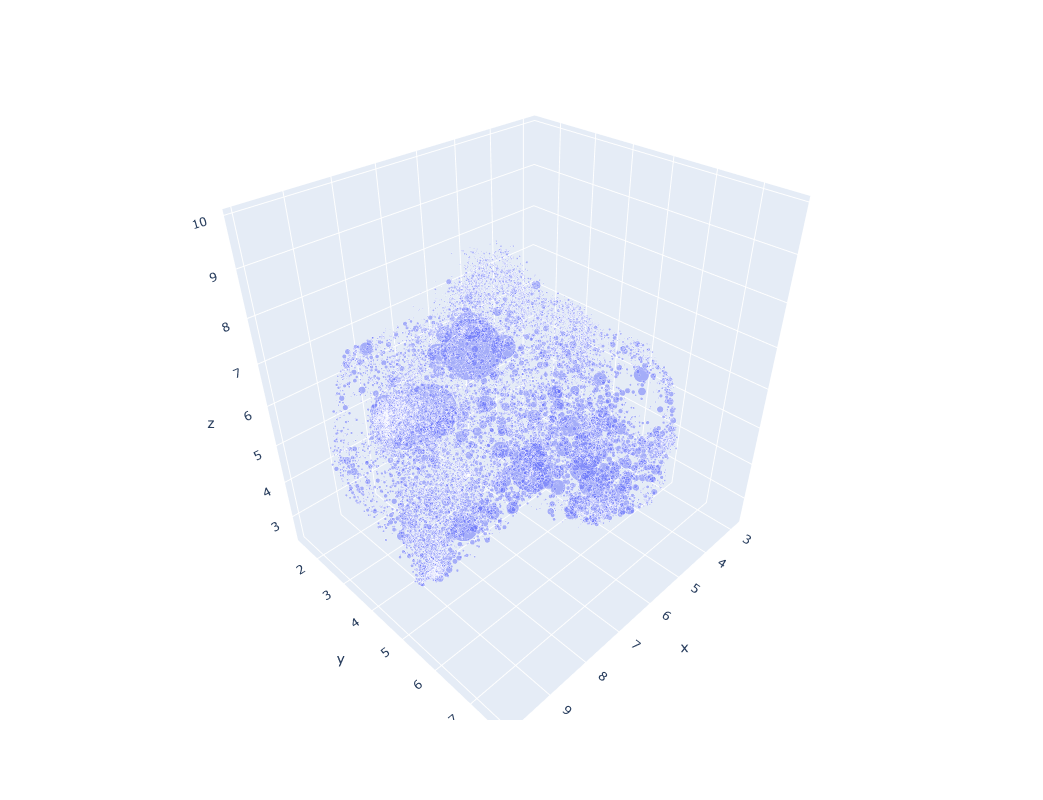

In [213]:
visuals = pd.DataFrame(embeddings, index=words, columns=['x', 'y', 'z'])
visuals['size'] = 0.01
visuals['node_type'] = [i.split(':')[0] if not (i.split(':')[1] == 'True') else 'Age' for i in visuals.index.tolist()]
visuals = visuals.reset_index()

user_lookup = pd.read_csv('accounts.csv', on_bad_lines='skip', low_memory=False).set_index('Id')[['Name', 'Followers', 'Estimated reach']].to_dict('index')

account_nodes = visuals[visuals['node_type'] == 'Account']
account_ids = account_nodes['index'].apply(lambda x: x.split(':')[1]).astype(int)
account_metadata = pd.DataFrame(account_ids.map(user_lookup).values.tolist(), index=account_ids)
account_metadata.index = [f'Account:{i}' for i in account_metadata.index]
account_metadata = account_metadata.reset_index()

final = visuals.merge(account_metadata, on='index', how='left')
final['Name'] = final['Name'].fillna('')

final['Followers'] = final['Followers'].fillna(0)
final['Log(Followers)'] = (final['Followers'] + 0.01).apply(np.log)

final['Estimated reach'] = final['Estimated reach'].fillna(0)
final['Log(Estimated reach)'] = np.log(final['Estimated reach'].fillna(0) + 0.01)

px.scatter_3d(
    final[final['node_type'] == 'Account'], x='x', y='y', z='z', 
    hover_data=['index', 'node_type', 'Name', 'Followers', 'Estimated reach'],
    size='Estimated reach', size_max=100, 
    opacity=0.5, width=800, height=800)

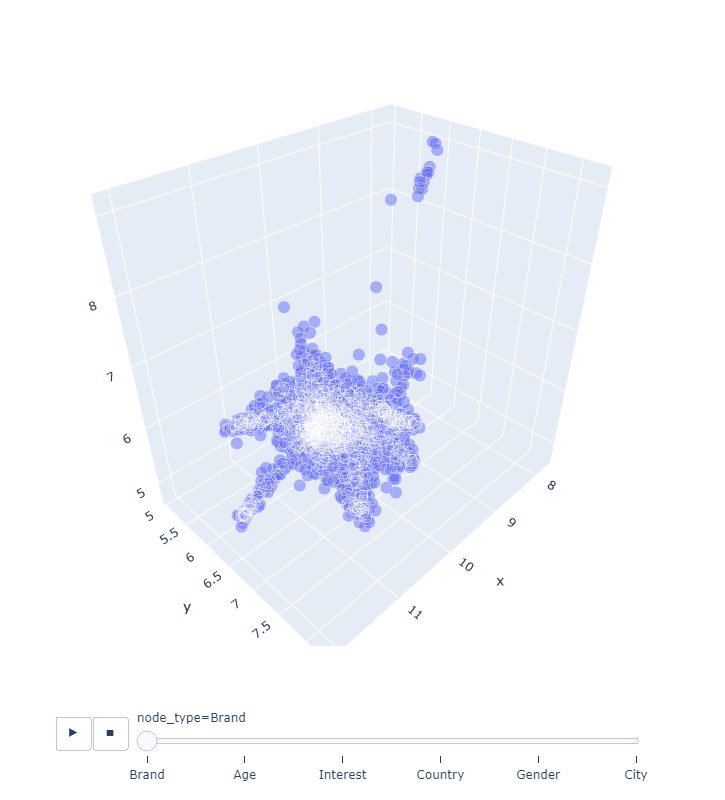

In [214]:
px.scatter_3d(
    final[final['node_type'] != 'Account'], x='x', y='y', z='z', 
    animation_frame='node_type', hover_data=['index', 'node_type'],
    size='size', opacity=0.5, width=800, height=800)

#### Exploring hidden relationships

In [215]:
soccer = ['Account:47702', 'Account:44207']  # Messi / Real Madrid
singer = ['Account:159', 'Interest:Luxury Goods']  # Dua Lipa

luxury_retail = ['Interest:Luxury Goods', 'Interest:Cars & Motorbikes']
print('----------- All Luxury Retail & Cars -----------')
for node_id, value in g2v.model.wv.most_similar_cosmul(positive=luxury_retail):
    if node_id.startswith('Account'):
        print(user_lookup[int(node_id.split(':')[1])], value)
    else:
        print(node_id, value)

italian_luxury = {'positive': luxury_retail + ['Country:Italy']}
print()
print('----------- Luxury Retail & Cars (in Italy) -----------')
for node_id, value in g2v.model.wv.most_similar_cosmul(**italian_luxury):
    if node_id.startswith('Account'):
        print(user_lookup[int(node_id.split(':')[1])], value)
    else:
        print(node_id, value)

----------- All Luxury Retail & Cars -----------
Brand:Mercedes-Benz 0.6325820684432983
Brand:Holden 0.6148250102996826
Brand:Ferrari 0.607988178730011
Brand:Jaguar 0.6010836958885193
Brand:Hot Wheels 0.5989167094230652
Brand:Alpina 0.5957804918289185
Brand:Rolls-Royce 0.5957787036895752
Brand:Suavecito 0.592768669128418
Brand:TAG Heuer 0.5853990912437439
Brand:Rolex 0.5801116228103638

----------- Luxury Retail & Cars (in Italy) -----------
Brand:Ermenegildo Zegna 0.42743340134620667
Brand:Ferrari 0.4120122194290161
Brand:Lancia 0.3931945264339447
Brand:Need for Speed 0.39265015721321106
Brand:Damiani 0.38271403312683105
Brand:Patrizia Pepe 0.38204169273376465
Brand:Alpina 0.37450936436653137
Brand:Trussardi 0.37044286727905273
Brand:Project CARS 0.3653073310852051
Brand:Armani 0.3623358905315399


In [216]:
# g2v_embeds.index = [i.replace(',', '').replace(' ', '-') for i in g2v_embeds.index]
# g2v_embeds.to_csv('wheel_model_clean.bin')